# Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edits:
- 2020/03/24 peeters (change dimensions order)
- 2020/04/27 peeters (added comments on W1, W2 initialization, added comments on A and B)
- 2021/05/05 peeters (add some documentation related to ```W1 -= ...```)
- 2023/05/10 peeters (typos corrections)
- 2024/05/02 peeters (link to do nn.Linear)

Read the "introduction to pytorch"
- slides: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/
- video: https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4


## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch.

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss: write it by-hand for Model A and use ```torch.nn.MSELoss``` for Model B and C.

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package.
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```.

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.

## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Load the python packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.



In [2]:
def F_do_dataset_parab(m):
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

def F_do_dataset_sin(m):
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

    # --- change vectos to matrix
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
    return x_data, y_data

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


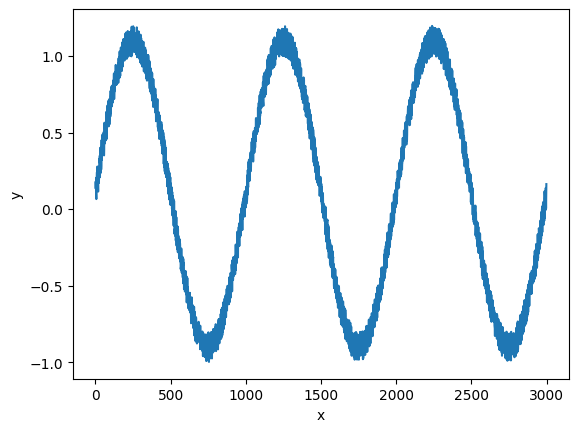

In [3]:
# --- Dataset 1
#x_data, y_data = F_do_dataset_parab(m=100)
# --- Dataset 2
x_data, y_data = F_do_dataset_sin(m=3000)

plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [4]:
# --- START CODE HERE
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
# --- END CODE HERE

## Hyper-parameters definition

In [5]:
n_in = 1
n_h = 10
n_out = 1

nb_epoch = 20000
learning_rate_alpha = 0.05
param_momentum = 0.01
param_L1_weight = 0.001
param_L2_weight = 0.01

## Model A (writting the network equations)

For model A, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```.

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable.
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```.

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [6]:
# --- START CODE HERE
W1 = torch.randn(n_in, n_h, requires_grad=True)
b1 = torch.randn(n_h, requires_grad=True)
W2 = torch.randn(n_h, n_out, requires_grad=True)
b2 = torch.randn(n_out, requires_grad=True)
# --- END CODE HERE

### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

In [7]:
def model(X):

    # --- H is the results of the first projection
    # --- H is then transformed by a non-linearity to A

    # --- START CODE HERE
    H = torch.matmul(X, W1) + b1
    A = torch.sigmoid(H)
    y_pred = torch.matmul(A, W2) + b2
    # --- END CODE HERE
    return y_pred

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

In [8]:
learning_rate_alpha=0.05

In [9]:
for epoch in range(0, nb_epoch):
    # --- X (m, n_in)
    # --- Y (m, n_out)
    # --- START CODE HERE
    y_pred = model(x_data)
    loss = torch.mean((y_pred - y_data)**2)
    # --- END CODE HERE

    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))

    loss.backward()

    with torch.no_grad():
        # --- START CODE HERE
        W1 -= learning_rate_alpha * W1.grad
        b1 -= learning_rate_alpha * b1.grad
        W2 -= learning_rate_alpha * W2.grad
        b2 -= learning_rate_alpha * b2.grad
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        # --- END CODE HERE


epoch 0, loss 7.773787975311279


epoch 1000, loss 0.9062223434448242
epoch 2000, loss 0.882268488407135
epoch 3000, loss 0.8721702694892883
epoch 4000, loss 0.866507351398468
epoch 5000, loss 0.8620545864105225
epoch 6000, loss 0.857042133808136
epoch 7000, loss 0.8471490740776062
epoch 8000, loss 0.8090413212776184
epoch 9000, loss 0.6559453010559082
epoch 10000, loss 0.4097355902194977
epoch 11000, loss 0.24879568815231323
epoch 12000, loss 0.18426141142845154
epoch 13000, loss 0.16355684399604797
epoch 14000, loss 0.157296285033226
epoch 15000, loss 0.15506604313850403
epoch 16000, loss 0.15376311540603638
epoch 17000, loss 0.1524980664253235
epoch 18000, loss 0.1509789079427719
epoch 19000, loss 0.14907829463481903


### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

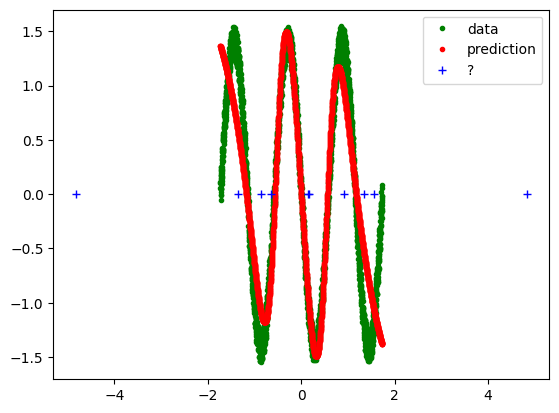

In [10]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.', label="data");
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r.', label="prediction");
# super-impose the biases of the first layer
plt.plot(b1.detach().numpy(), np.zeros((10,1)), 'b+', label="?");
plt.legend()
plt.show()

## Model B (using Sequential class)

Here, you will write the network using the nn.Sequential class.
With this you can use the ready-made layers ``torch.nn.Linear``,``torch.nn.Tanh``, ...

In [14]:
# --- START CODE HERE
model = nn.Sequential(
    nn.Linear(n_in, n_h),
    nn.Sigmoid(),
    nn.Linear(n_h, n_out)
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_alpha)
criterion = nn.MSELoss()

for epoch in range(nb_epoch):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))
    
    optimizer.zero_grad()
    #model.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    #with torch.no_grad():
    #    for param in model.parameters():
    #        param -= learning_rate_alpha * param.grad
# --- END CODE HERE

epoch 0, loss 1.0728168487548828
epoch 1000, loss 0.9370610117912292
epoch 2000, loss 0.9356483817100525
epoch 3000, loss 0.9346509575843811
epoch 4000, loss 0.9332594275474548
epoch 5000, loss 0.9284104704856873
epoch 6000, loss 0.9089957475662231
epoch 7000, loss 0.8885132074356079
epoch 8000, loss 0.8792409896850586
epoch 9000, loss 0.8732141256332397
epoch 10000, loss 0.8686835169792175
epoch 11000, loss 0.8651228547096252
epoch 12000, loss 0.8622289299964905
epoch 13000, loss 0.8598127961158752
epoch 14000, loss 0.8577505946159363
epoch 15000, loss 0.8559570908546448
epoch 16000, loss 0.8543704152107239
epoch 17000, loss 0.8529441952705383
epoch 18000, loss 0.8516419529914856
epoch 19000, loss 0.8504335880279541


## Model C (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```.

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- START CODE HERE
        self.linear1 = torch.nn.Linear(n_in, n_h)
        self.linear2 = torch.nn.Linear(n_h, n_out)
        # --- END CODE HERE

    def forward(self, x):

        # --- START CODE HERE
        h_relu = torch.sigmoid(self.linear1(x))
        y_pred = self.linear2(h_relu)
        # --- END CODE HERE

        return y_pred

# --- START CODE HERE
model = Net()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_alpha)

for epoch in range(nb_epoch):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
# --- END CODE HERE

epoch 0, loss 1.0095806121826172
epoch 1000, loss 0.9360687136650085
epoch 2000, loss 0.9350205659866333
epoch 3000, loss 0.934197187423706
epoch 4000, loss 0.932790994644165
epoch 5000, loss 0.9272895455360413
epoch 6000, loss 0.9065496325492859
epoch 7000, loss 0.8866289258003235
epoch 8000, loss 0.8778929710388184
epoch 9000, loss 0.8721464276313782
epoch 10000, loss 0.8677920699119568
epoch 11000, loss 0.8643391132354736
epoch 12000, loss 0.8615055084228516
epoch 13000, loss 0.8591148853302002
epoch 14000, loss 0.857049822807312
epoch 15000, loss 0.8552272319793701
epoch 16000, loss 0.853584885597229
epoch 17000, loss 0.8520737886428833
epoch 18000, loss 0.8506531715393066
epoch 19000, loss 0.8492870330810547


## Model B+C

### Criterion and Optimization

The code of Model A is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model B) or a class definition of the network (model C), we still need to define
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [16]:
# --- START CODE HERE

model = Net()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_alpha)

# --- END CODE HERE

### Training

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

In [17]:
loss_l = []
for epoch in range(nb_epoch):

    # --- START CODE HERE
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # --- END CODE HERE

    loss_l.append(loss)
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))

epoch 0, loss 0.9850379824638367
epoch 1000, loss 0.9358708262443542
epoch 2000, loss 0.9346665143966675
epoch 3000, loss 0.9322715401649475
epoch 4000, loss 0.9229010939598083
epoch 5000, loss 0.900306224822998
epoch 6000, loss 0.8854098320007324
epoch 7000, loss 0.8773946762084961
epoch 8000, loss 0.8713606595993042
epoch 9000, loss 0.8663989305496216
epoch 10000, loss 0.8620542287826538
epoch 11000, loss 0.8579854965209961
epoch 12000, loss 0.8539495468139648
epoch 13000, loss 0.8497985005378723
epoch 14000, loss 0.8454625010490417
epoch 15000, loss 0.8409104943275452
epoch 16000, loss 0.8360994458198547
epoch 17000, loss 0.8309003710746765
epoch 18000, loss 0.8250021934509277
epoch 19000, loss 0.8178306221961975


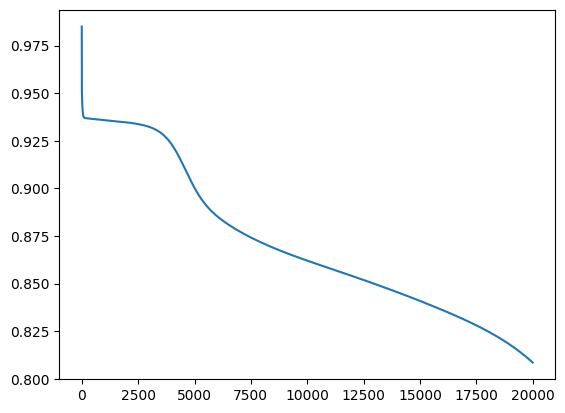

In [18]:
# ----------------
plt.plot([loss.detach().numpy() for loss in loss_l]);

### Plotting results

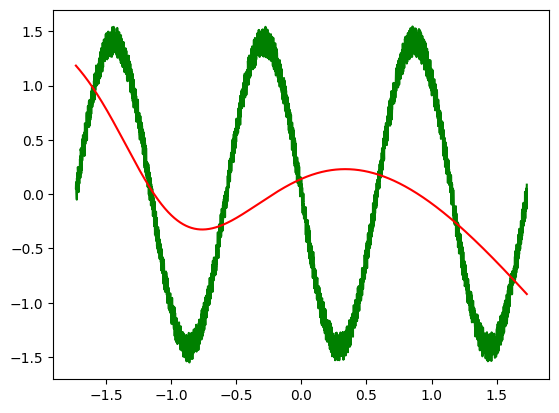

In [19]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), y_pred.detach().numpy(), 'r')

### Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

[[ 3.8434505e+00]
 [-1.6882658e-01]
 [ 3.7180696e+00]
 [-7.3864478e-01]
 [ 4.6579590e-01]
 [-4.5779836e-01]
 [-2.5238135e+00]
 [ 2.5677288e+00]
 [-1.9420788e+00]
 [ 4.5029092e-06]]
[-1.3200766e+00 -6.5293050e-01 -3.2768338e+00  9.7851336e-01
  1.2602328e-01 -9.4077253e-01 -2.1635163e+00  6.9471908e-01
  1.5473630e+00  3.8184389e-06]
[[ 2.0407126e+00  1.3558772e-01 -1.0217048e+00  8.8162065e-01
  -4.1702381e-01 -3.0600116e-01  2.4636841e+00 -2.2988701e+00
  -1.9762735e+00  4.7982180e-06]]
[4.1512365]


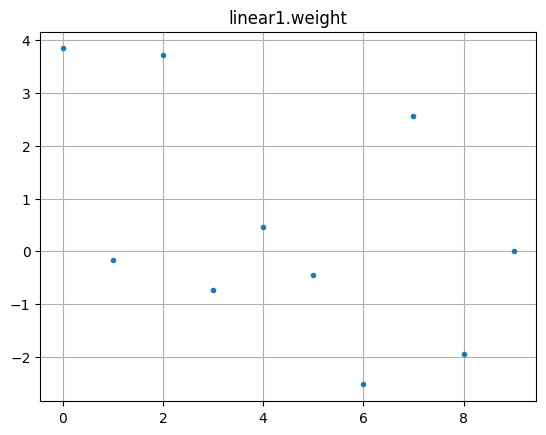

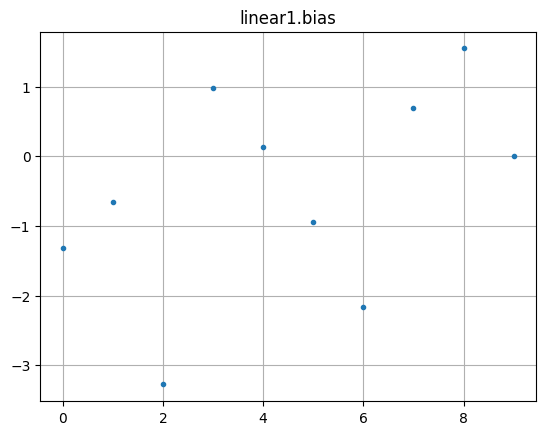

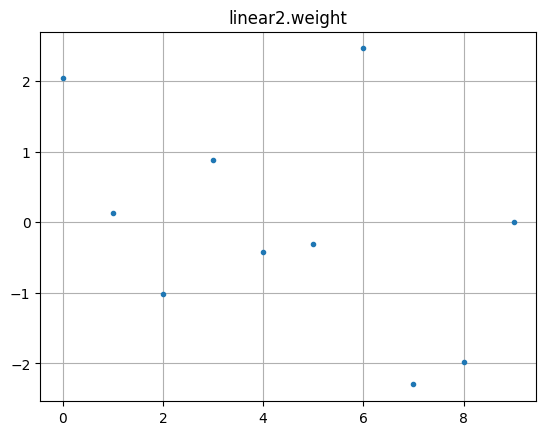

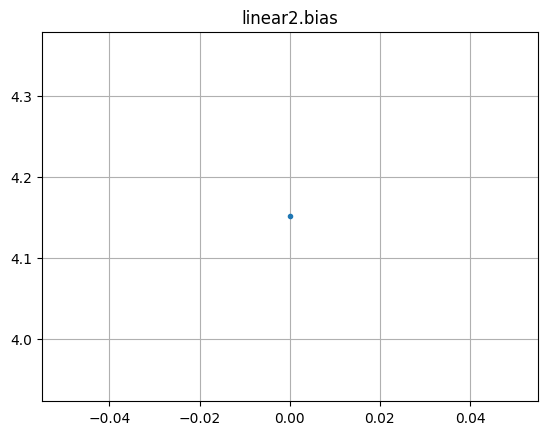

In [19]:
list_l = [{'name':name, 'data':layer.data} for name, layer in model.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())